# PyMC model

This notebook shows a PyMC model that incorporates basket + clustering

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import sys
from os.path import exists

sys.path.append('..')
sys.path.append('.')

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from sklearn.metrics import mean_squared_error
from scipy.stats import halfnorm
import math
from statsmodels.formula.api import glm
import statsmodels.api as sm
import seaborn as sns

from scipy import stats
from scipy.special import expit as logistic

In [4]:
from pyBasket.common import load_obj
from pyBasket.preprocessing import get_pivot_count_df
from pyBasket.model import get_patient_model_simple, get_patient_model_hierarchical
from pyBasket.model import get_patient_model_hierarchical_log_odds, get_patient_model_hierarchical_log_odds_nc
from pyBasket.model import get_model_simple, get_model_bhm, get_model_bhm_nc

## 1. Generate some data

In [5]:
np.random.seed(42)

New generative process

In [6]:
# Define number of patients, tissues, and clusters
n_patients = 500
n_tissues = 25
n_clusters = 10

# Generate tissue and cluster indices for each patient
basket_coords = np.arange(n_tissues)
cluster_coords = np.arange(n_clusters)
basket_idx = np.random.choice(basket_coords, size=n_patients)
cluster_idx = np.random.choice(cluster_coords, size=n_patients)

# Generate synthetic responsiveness data
theta_basket = np.random.normal(loc=0, scale=2, size=n_tissues)

# Generate unique prior mean and std for each column in theta_cluster
prior_means = np.random.normal(loc=0, scale=2, size=n_clusters)
prior_std_mean = 0 # mean of the half-normal distribution
prior_std_std = 1 # standard deviation of the half-normal distribution
prior_std_scale = np.sqrt(2) * prior_std_std / np.pi
prior_stds = halfnorm.rvs(loc=prior_std_mean, scale=prior_std_scale, size=n_clusters)

theta_cluster = np.zeros((n_tissues, n_clusters))
for i in range(n_clusters):
    theta_cluster[:,i] = np.random.normal(loc=prior_means[i], scale=prior_stds[i], size=n_tissues)

true_basket_p = logistic(theta_basket)
true_cluster_p = logistic(theta_cluster)
true_basket_reshaped = true_basket_p.reshape((n_tissues, 1))
true_mat = true_basket_reshaped * true_cluster_p

true_patient_p = true_mat[basket_idx, cluster_idx]
is_responsive = np.random.binomial(n=1, p=true_patient_p)

# Create synthetic data dataframe
data_df = pd.DataFrame({
    'basket_number': basket_idx,
    'cluster_number': cluster_idx,
    'responsive': is_responsive
})

# Print the first few rows of the data dataframe
data_df

,basket_number,cluster_number,responsive
0,6,6,0
1,19,3,0
2,14,0,0
3,10,4,1
4,7,6,0
...,...,...,...
495,4,8,0
496,11,4,0
497,15,2,0
498,15,4,0


In [7]:
true_basket_df = pd.DataFrame({'prob': true_basket_p, 'basket': range(len(true_basket_p))})

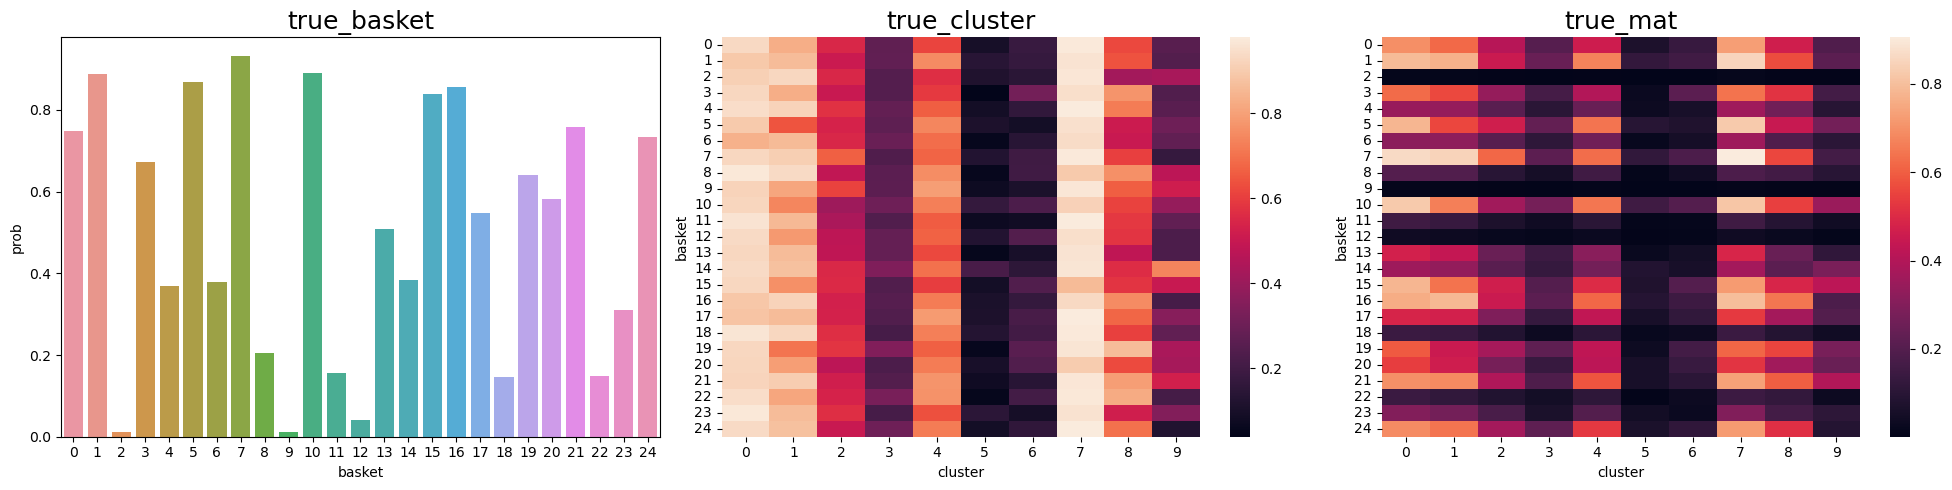

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

sns.barplot(data=true_basket_df, x='basket', y='prob', ax=ax1)
sns.heatmap(true_cluster_p, ax=ax2)
sns.heatmap(true_mat, ax=ax3)

ax1.set_title('true_basket', fontsize=18)
ax2.set_title('true_cluster', fontsize=18)
ax2.set_xlabel('cluster')
ax2.set_ylabel('basket')
ax3.set_title('true_mat', fontsize=18)
ax3.set_xlabel('cluster')
ax3.set_ylabel('basket')
plt.tight_layout()

Convert data_df into the format some models want.

In [9]:
df_pivot = get_pivot_count_df(data_df)
df_pivot

,n_success,n_trial
basket_number,,
0,12,30
1,13,20
2,0,28
3,6,16
4,1,21
5,8,14
6,4,23
7,13,23
8,0,18


## 2. Define models

No. of samples to collect before and after burn-in during MCMC.

In [10]:
n_burn_in = int(5E3)
n_sample = int(5E3)
target_accept = 0.99

### Simple model

In [11]:
model_s = get_model_simple(df_pivot)

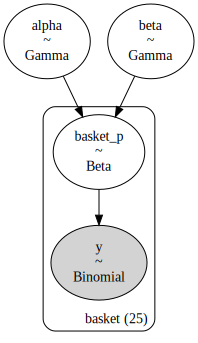

In [12]:
pm.model_to_graphviz(model_s)

In [13]:
with model_s:
    trace_s = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, basket_p]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 35 seconds.


In [14]:
az.summary(trace_s).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.00,0.32,0.46,1.60,0.00,0.00,7763.0,11243.0,1.0
beta,2.64,0.88,1.16,4.30,0.01,0.01,9768.0,13000.0,1.0
basket_p[0],0.39,0.08,0.23,0.54,0.00,0.00,30197.0,14341.0,1.0
basket_p[1],0.59,0.10,0.41,0.78,0.00,0.00,28150.0,14152.0,1.0
basket_p[2],0.03,0.03,0.00,0.09,0.00,0.00,12325.0,7943.0,1.0
basket_p[3],0.36,0.11,0.16,0.56,0.00,0.00,28042.0,13025.0,1.0
basket_p[4],0.08,0.06,0.00,0.18,0.00,0.00,20485.0,9178.0,1.0
basket_p[5],0.51,0.12,0.30,0.74,0.00,0.00,25277.0,14558.0,1.0
basket_p[6],0.19,0.07,0.06,0.33,0.00,0.00,23236.0,13438.0,1.0
basket_p[7],0.53,0.10,0.35,0.71,0.00,0.00,27014.0,14541.0,1.0


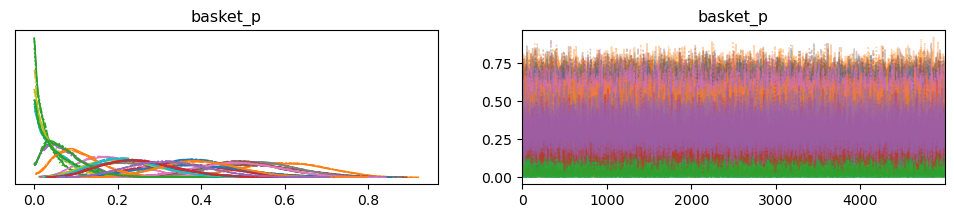

In [15]:
az.plot_trace(trace_s, var_names=['basket_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

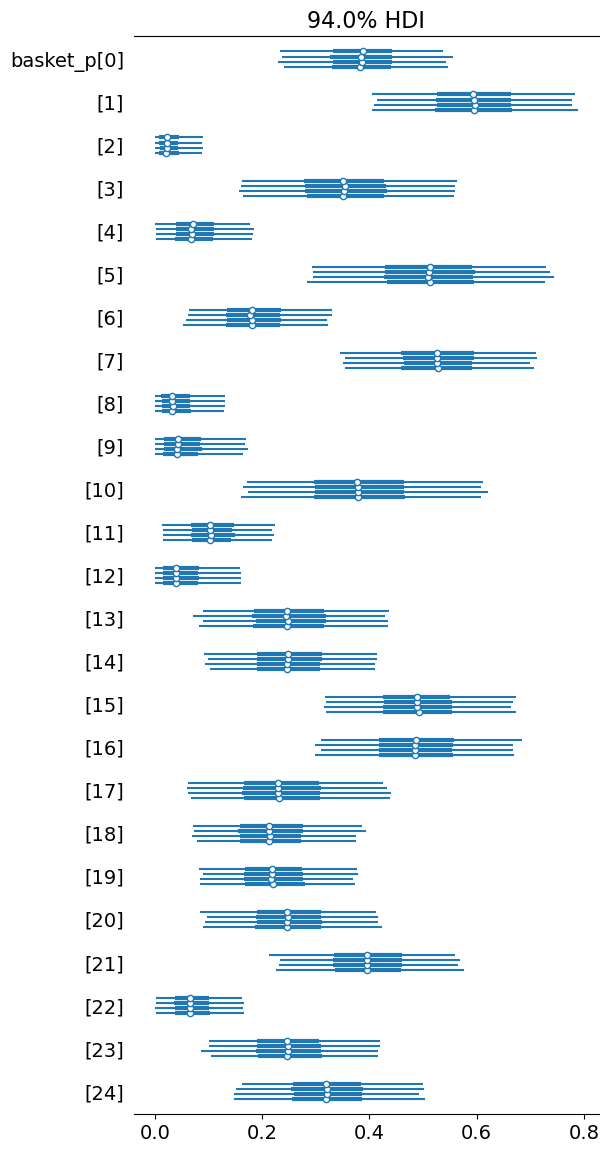

In [16]:
az.plot_forest(trace_s, var_names=['basket_p'])

In [17]:
stacked_s = az.extract(trace_s)

In [18]:
inferred_basket_p = np.mean(stacked_s.basket_p.values, axis=1)
true_basket_p.shape, inferred_basket_p.shape, math.sqrt(mean_squared_error(true_basket_p, inferred_basket_p))

((25,), (25,), 0.2854548774334756)

### BHM (see Berry 2013)

In [19]:
model_bhm = get_model_bhm(df_pivot)

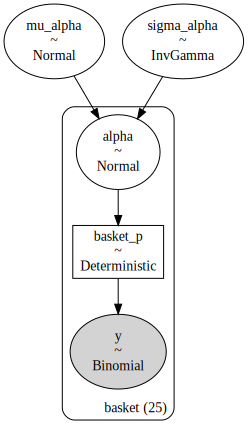

In [20]:
pm.model_to_graphviz(model_bhm)

This is what we actually run

In [21]:
model_bhm = get_model_bhm_nc(df_pivot)

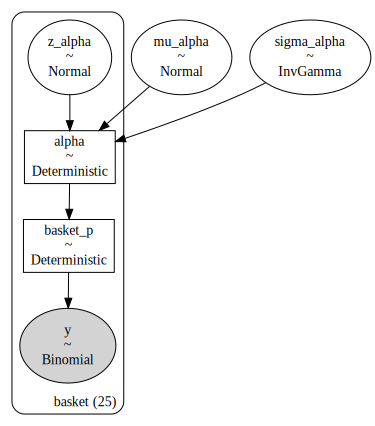

In [22]:
pm.model_to_graphviz(model_bhm)

In [23]:
with model_bhm:
    trace_h1 = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z_alpha, mu_alpha, sigma_alpha]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 33 seconds.


In [24]:
az.summary(trace_h1).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z_alpha[0],0.64,0.39,-0.08,1.39,0.0,0.0,8326.0,12427.0,1.0
z_alpha[1],1.38,0.46,0.52,2.25,0.0,0.0,8253.0,12164.0,1.0
z_alpha[2],-1.62,0.65,-2.83,-0.43,0.0,0.0,16714.0,13697.0,1.0
z_alpha[3],0.50,0.47,-0.41,1.37,0.0,0.0,12242.0,12853.0,1.0
z_alpha[4],-1.03,0.60,-2.19,0.04,0.0,0.0,15452.0,12797.0,1.0
...,...,...,...,...,...,...,...,...,...
basket_p[20],0.25,0.09,0.10,0.42,0.0,0.0,25534.0,13446.0,1.0
basket_p[21],0.39,0.09,0.22,0.57,0.0,0.0,28191.0,16140.0,1.0
basket_p[22],0.08,0.05,0.01,0.18,0.0,0.0,18725.0,12808.0,1.0
basket_p[23],0.25,0.09,0.09,0.40,0.0,0.0,27411.0,15009.0,1.0


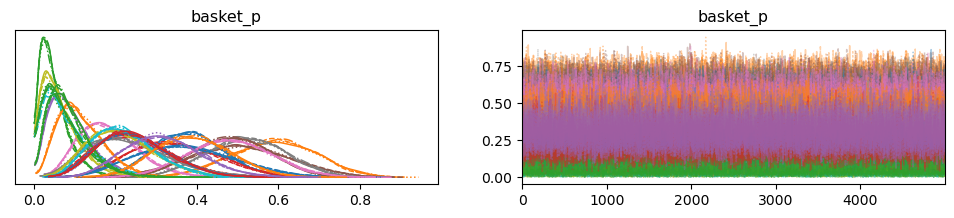

In [25]:
az.plot_trace(trace_h1, var_names=['basket_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

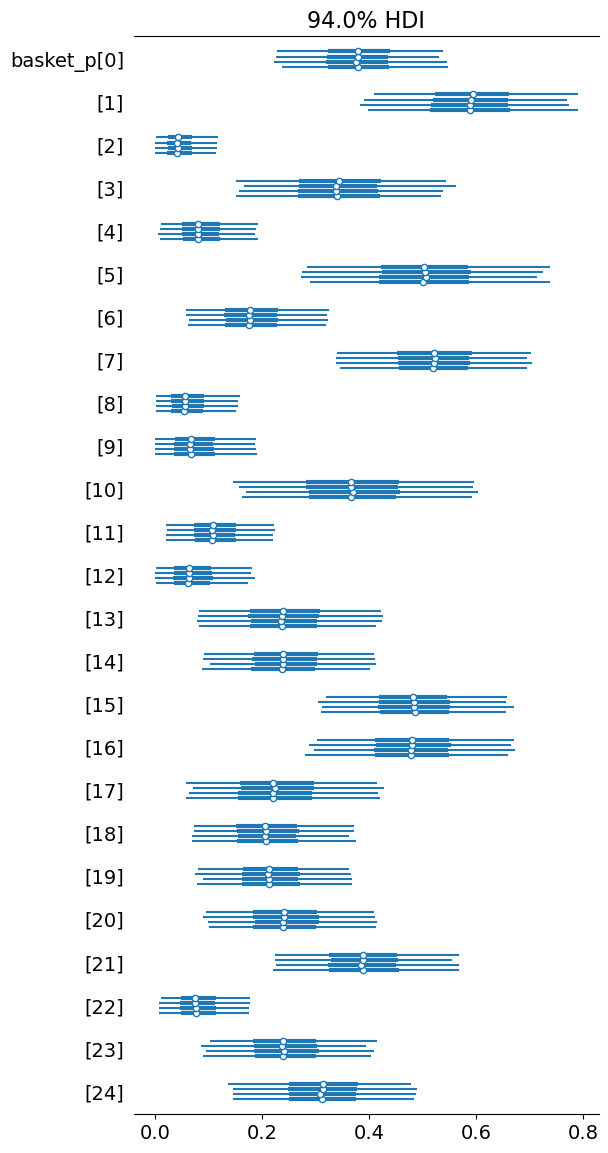

In [26]:
az.plot_forest(trace_h1, var_names=['basket_p'])

In [27]:
stacked_h1 = az.extract(trace_h1)

In [28]:
inferred_basket_p = np.mean(stacked_h1.basket_p.values, axis=1)
true_basket_p.shape, inferred_basket_p.shape, math.sqrt(mean_squared_error(true_basket_p, inferred_basket_p))

((25,), (25,), 0.29021116556054244)

### Hierarchical model 2

Another hierarchical model, but modelling the log-odds instead.

In [29]:
model_h2 = get_patient_model_hierarchical_log_odds(data_df)

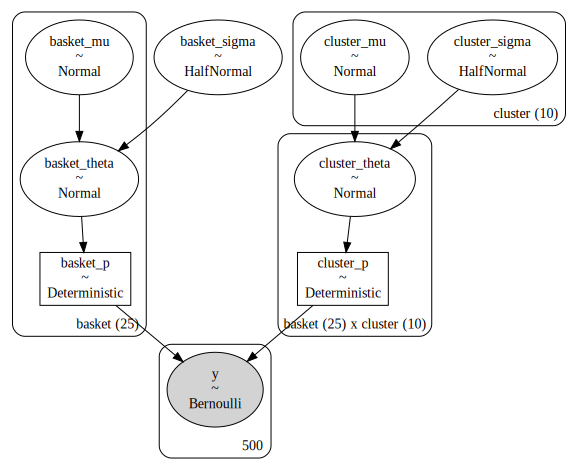

In [30]:
pm.model_to_graphviz(model_h2)

In [31]:
# with model_h2:
#     trace_h2 = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True})

This is the one we actually use after reparameterisation.

In [32]:
model_h2_nc = get_patient_model_hierarchical_log_odds_nc(data_df)

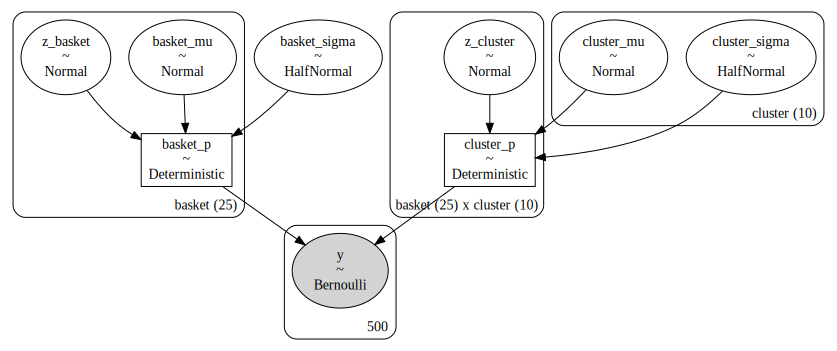

In [33]:
pm.model_to_graphviz(model_h2_nc)

In [34]:
with model_h2_nc:
    trace_h2 = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z_basket, z_cluster, basket_mu, cluster_mu, basket_sigma, cluster_sigma]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 113 seconds.
There were 142 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6732, but should be close to 0.8. Try to increase the number of tuning steps.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7078, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


In [35]:
az.summary(trace_h2).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z_basket[6],0.22,0.95,-1.59,1.98,0.01,0.01,9435.0,11423.0,1.0
z_basket[19],0.44,0.98,-1.44,2.24,0.01,0.01,9464.0,10335.0,1.0
z_basket[14],-0.49,0.98,-2.27,1.41,0.01,0.01,8061.0,7701.0,1.0
z_basket[10],0.12,0.94,-1.69,1.89,0.01,0.01,11255.0,10553.0,1.0
z_basket[7],-0.30,0.97,-2.18,1.47,0.02,0.02,2637.0,1359.0,1.0
...,...,...,...,...,...,...,...,...,...
"cluster_p[12, 5]",0.12,0.10,0.00,0.30,0.00,0.00,15136.0,11208.0,1.0
"cluster_p[12, 1]",0.26,0.17,0.00,0.55,0.00,0.00,8412.0,9696.0,1.0
"cluster_p[12, 2]",0.92,0.09,0.77,1.00,0.00,0.00,3505.0,2626.0,1.0
"cluster_p[12, 7]",0.59,0.18,0.25,0.95,0.00,0.00,9744.0,7000.0,1.0


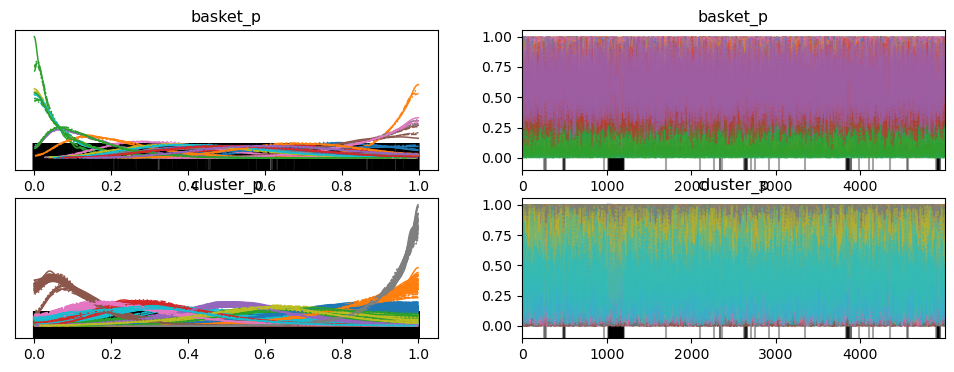

In [36]:
az.plot_trace(trace_h2, var_names=['basket_p', 'cluster_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

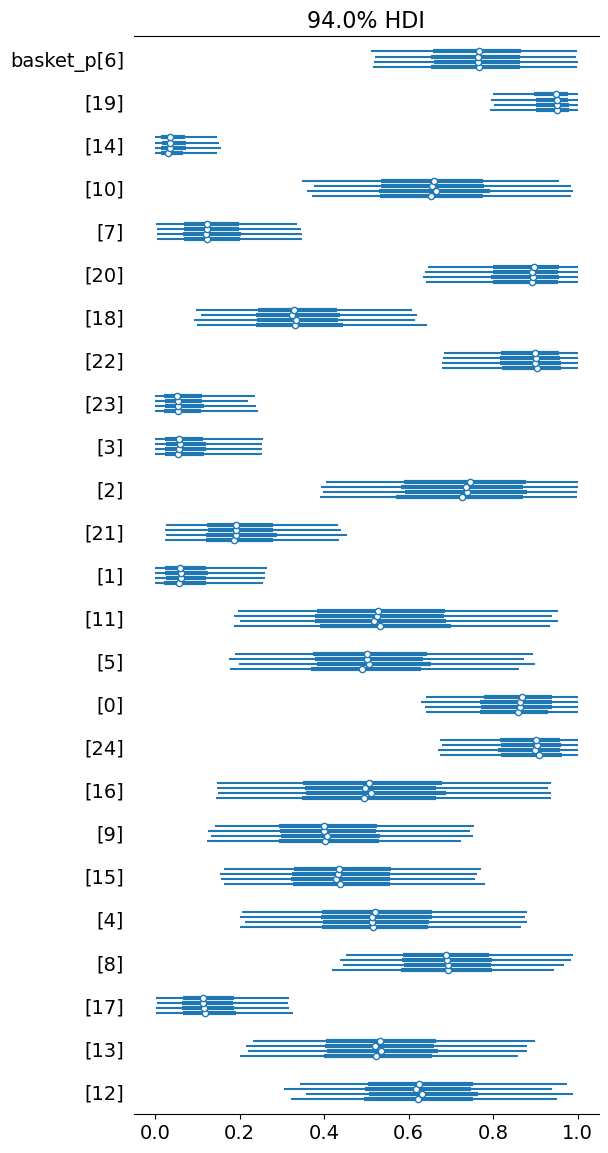

In [37]:
az.plot_forest(trace_h2, var_names=['basket_p'])

In [38]:
stacked_h2 = az.extract(trace_h2)

In [39]:
inferred_basket_p = np.mean(stacked_h2.basket_p.values, axis=1)
true_basket_p.shape, inferred_basket_p.shape, math.sqrt(mean_squared_error(true_basket_p, inferred_basket_p))

((25,), (25,), 0.11236330468381829)

In [40]:
inferred_cluster_p = np.mean(stacked_h2.cluster_p.values, axis=2)
true_cluster_p.shape, inferred_cluster_p.shape, math.sqrt(mean_squared_error(true_cluster_p, inferred_cluster_p))

((25, 10), (25, 10), 0.11438197891198895)

In [41]:
inferred_basket_p_tiled = np.tile(inferred_basket_p, (n_clusters, 1)).T
inferred_mat_h2 = inferred_basket_p_tiled * inferred_cluster_p
true_mat.shape, inferred_basket_p_tiled.shape, inferred_mat_h2.shape

((25, 10), (25, 10), (25, 10))

## 3. Calculate RMSE

Calculate root mean squared error for basket_p

In [42]:
sns.set_context('poster')

In [43]:
actual = true_basket_p

predicted_basket_s = np.mean(stacked_s.basket_p.values, axis=1)
predicted_basket_s_df = pd.DataFrame({'prob': predicted_basket_s, 'basket': range(len(predicted_basket_s))})
rmse_s = math.sqrt(mean_squared_error(actual, predicted_basket_s))

predicted_basket_h1 = np.mean(stacked_h1.basket_p.values, axis=1)
predicted_basket_h1_df = pd.DataFrame({'prob': predicted_basket_h1, 'basket': range(len(predicted_basket_h1))})
rmse_h1 = math.sqrt(mean_squared_error(actual, predicted_basket_h1))

predicted_basket_h2 = np.mean(stacked_h2.basket_p.values, axis=1)
predicted_basket_h2_df = pd.DataFrame({'prob': predicted_basket_h2, 'basket': range(len(predicted_basket_h2))})
rmse_h2 = math.sqrt(mean_squared_error(actual, predicted_basket_h2))

rmse_basket_p = pd.DataFrame({
    'method': ['Simple', 'BHM', 'pyBasket'],
    'RMSE': [rmse_s, rmse_h1, rmse_h2]
})
rmse_basket_p

,method,RMSE
0,Simple,0.285455
1,BHM,0.290211
2,pyBasket,0.112363


Calculate root mean squared error for cluster_p

In [44]:
actual = true_cluster_p

predicted_cluster_h2 = np.mean(stacked_h2.cluster_p.values, axis=2)
rmse_h2 = math.sqrt(mean_squared_error(actual, predicted_cluster_h2))

rmse_cluster_p = pd.DataFrame({
    'method': ['pyBasket'],
    'RMSE': [rmse_h2]
})
rmse_cluster_p

,method,RMSE
0,pyBasket,0.114382


Make plot

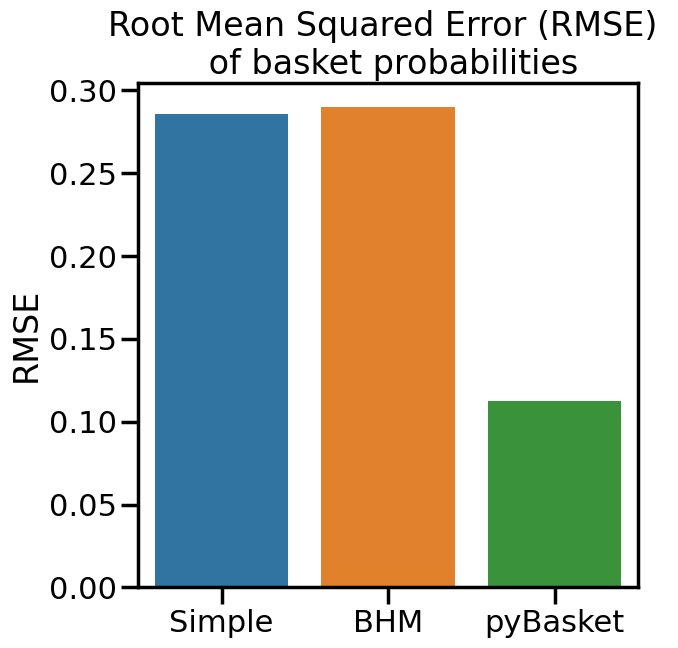

In [45]:
methods = rmse_basket_p['method'].unique()
colors = sns.color_palette("deep", len(methods))
color_map = dict(zip(methods, colors))

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))

sns.barplot(x='method', y='RMSE', data=rmse_basket_p, ax=ax1)
ax1.set_title('Root Mean Squared Error (RMSE) \n of basket probabilities')
plt.xlabel(None)
plt.tight_layout()
plt.savefig('results/report_rmse.png', dpi=300)

Compare the matrices

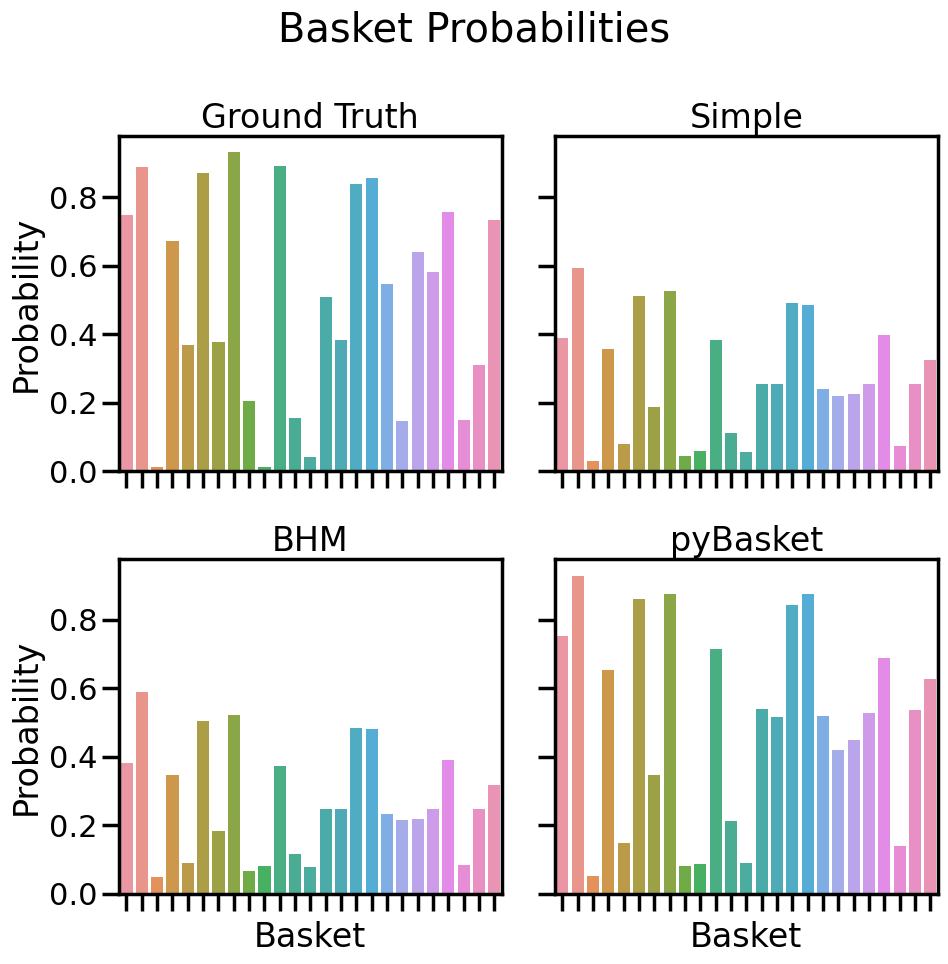

In [46]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

sns.barplot(data=true_basket_df, x='basket', y='prob', ax=ax[0][0])
ax[0][0].set_title('Ground Truth')
ax[0][0].set_xlabel(None)
ax[0][0].set_ylabel('Probability')

sns.barplot(data=predicted_basket_s_df, x='basket', y='prob', ax=ax[0][1])
ax[0][1].set_title('Simple')
ax[0][1].set_xlabel(None)
ax[0][1].set_ylabel(None)

sns.barplot(data=predicted_basket_h1_df, x='basket', y='prob', ax=ax[1][0])
ax[1][0].set_title('BHM')
ax[1][0].set_ylabel('Probability')
ax[1][0].set_xlabel('Basket')

sns.barplot(data=predicted_basket_h2_df, x='basket', y='prob', ax=ax[1][1])
ax[1][1].set_title('pyBasket')
ax[1][1].set_ylabel(None)
ax[1][1].set_xticklabels([])
ax[1][1].set_xlabel('Basket')

plt.suptitle('Basket Probabilities')
plt.tight_layout()
plt.savefig('results/report_synthetic_10_basket_probs.png', dpi=300)

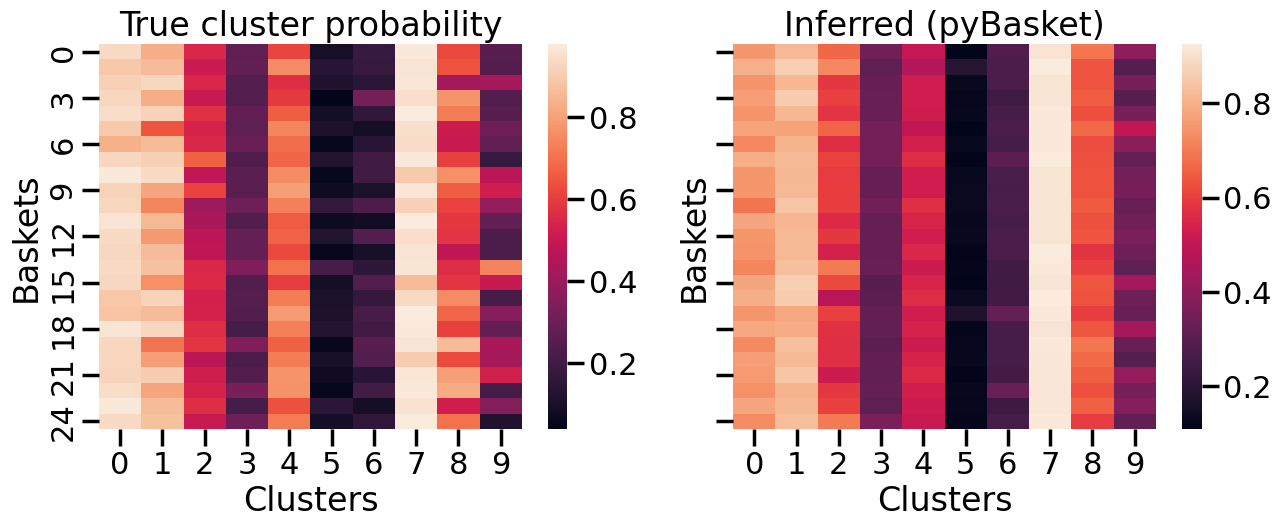

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)

sns.heatmap(true_cluster_p, ax=ax[0])
ax[0].set_title('True cluster probability')
ax[0].set_xlabel('Clusters')
ax[0].set_ylabel('Baskets')
        
sns.heatmap(predicted_cluster_h2, ax=ax[1])
ax[1].set_title('Inferred (pyBasket)')
ax[1].set_xlabel('Clusters')
ax[1].set_ylabel('Baskets')
plt.savefig('results/report_synthetic_10_cluster_probs.png', dpi=300)

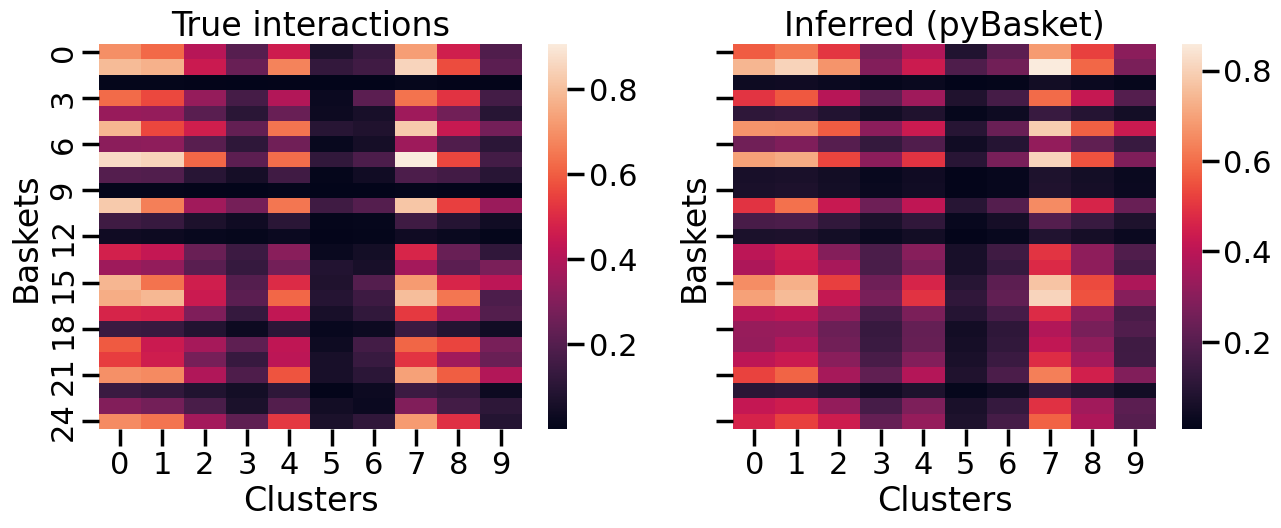

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)

sns.heatmap(true_mat, ax=ax[0])
ax[0].set_title('True interactions')
ax[0].set_xlabel('Clusters')
ax[0].set_ylabel('Baskets')
        
sns.heatmap(inferred_mat_h2, ax=ax[1])
ax[1].set_title('Inferred (pyBasket)')
ax[1].set_xlabel('Clusters')
ax[1].set_ylabel('Baskets')
plt.savefig('results/report_synthetic_10_interactions.png', dpi=300)